In [187]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import keras
import random

In [188]:
#getting the size of the convolution layer sizes

##convolution layer 1
filterSize1=5
numFilters1=16

##convolution layer 2
filterSize2= 5
numFilters2=36

##the final fully connected layer size
fullConnect=128

In [189]:
(trainImages, trainLabels), (testImages,testLabels) = tf.keras.datasets.fashion_mnist.load_data()

In [190]:
labelDict={0:"top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}


In [191]:
print("No of training examples: \t\t{}".format(len(trainImages)))
print("No of test examples: \t\t\t{}".format(len(testImages)))

No of training examples: 		60000
No of test examples: 			10000


28


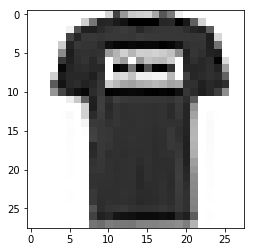

In [192]:
#parameters to pass through different layers
imgSize=trainImages[0].shape[0]
print(imgSize)
imgShape=trainImages[0].shape
plt.imshow(trainImages[1],cmap='binary')

In [193]:
def plotImages(trainImages,trainLabels):  
    for i in range(1,10):
        rand=random.randrange(0,60000)
        plt.subplot(3,3,i)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        plt.imshow(trainImages[rand],cmap="binary")
        plt.xlabel(labelDict[trainLabels[rand]])

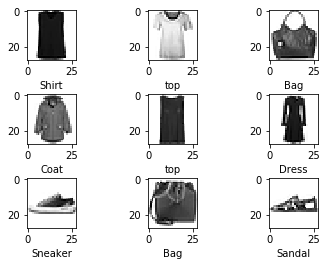

In [194]:

plotImages(trainImages,trainLabels)

In [195]:
#make a variable with some intial random values of the particular shape
def makeWeights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [196]:
def newBiases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [197]:
shape=(63,28,28)
a=np.empty(shape,dtype=np.float)


In [198]:
def makeRandomBatches(trainExamples,labels,size):
    start=random.randrange(0,len(trainExamples))
    trainBatch=trainExamples[start:start+size]
    trainLabels=labels[start:start+size]
    return trainBatch,trainLabels

'Coat'

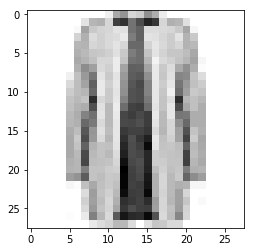

In [199]:
t,l=makeRandomBatches(trainImages,trainLabels,64)
plt.imshow(t[63],cmap='binary')
labelDict[l[63]]

In [200]:
def makeConvLayer(inputLayer,
                  filterSize,
                  inputChannels,
                  numFilters,
                  maxPooling=True):
    
    
    #IMPORTANT - The shape of filter is a tensor because it has to convolve with as many
    #layers of the conv layer. if the conv layer has 256 layers, then a 5x5 filter with 
    #256 channels will be used to make a new layer in the convolution!
    
    #shape of a filter is determined in the following way
    ##shape=[no. of slides at a time of the filter,
    ##       dimensionality of the filter,
    ##        num of channels of filter,
    ##         number of filters]
    
    #in general a 4D tensor has the following format
    ##tensor=[Image number,
    ##            Y axis of each image,
    ##            X axis of the image,
    ##            Channels of each image]
    
    #NOTE: this is different from the way the shape of the filter is setup
    
    #strides is in the format of the tensor 
    ##strides=[Image Number=1 (because you stride over the same image)
    ##            steps in Y axis ,
    ##            steps in X axis,
    ##            Channels of each image=1]
       
    shape=[filterSize,filterSize,inputChannels,numFilters]

    #now make a filter with the random weights
    weights=makeWeights(shape=shape)
    
    #make biases which is a 1D vector
    biases=newBiases(length=numFilters)
    
    layer=tf.nn.conv2d(input=inputLayer,
                      filter=weights,
                      strides=[1,1,1,1],
                       padding="SAME")
    
    #addding the biases to the layers
    layer+=biases
    
    if(maxPooling):
        layer=tf.nn.max_pool(value=layer,
                            ksize=[1,2,2,1],
                            strides=[1,2,2,1],padding="SAME")
        
    #adding the nonlinearity with ReLU
    layer=tf.nn.relu(layer)
    
    return layer,weights

In [201]:

#the output of a conv layer is 4-D while a fully connected layer takes in only
#2-D tensor

def flattenLayer(layer):
    layerShape=layer.get_shape()
    #currently the layerShape is set to,
    ## layerShape=[numImages,imgXsize,imgYsize,no. of channels]
    ## this is to be reshaped in to the format 
    ## layerShape=[numImages,imgXsize*imgYsize*no.of channels]
    numFeatures=layerShape[1:4].num_elements()
    
    flatLayer=tf.reshape(layer,[-1,numFeatures])
    
    return flatLayer,numFeatures
    

In [202]:
# the input is a 2D 
def fullConnected(input,
                 numInputs,    #previous layer shape
                 numOutputs,   #req. outptus
                 useRelu=True):
    #dont get confused here, if there are n inouts and m outputs
    #you need to have n*m weights and that is what this thing is doing
    weights=makeWeights(shape=[numInputs,numOutputs])
    biases=newBiases(length=numOutputs)
    
    layer=tf.matmul(input,weights)+biases
    
    if useRelu:
        layer=tf.nn.relu(layer)
    return layer 
    

In [203]:
#getting to work with the tensorflow placeholders and this will create inputs
#None is because of the fact that it can take any arbitrary values.
inputImage=tf.placeholder(tf.float32,shape=[None,imgSize,imgSize])

inputResized=tf.reshape(inputImage,shape=[-1,28,28,1])

#output place holder for the outputs from the graph
outputPlaceholder=tf.placeholder(tf.float32,shape=[None,10])
outputModel=tf.argmax(outputPlaceholder,axis=1)
#placeholder for the true labels. this is because the cost function will take 
#in the arguements in the tensor format.
trueOutput=tf.placeholder(tf.float32,shape=[None,10],name='trueOutput')
outputTrue=tf.argmax(trueOutput,axis=1)


In [204]:
#first conv layer 
convLayer1,weights1=makeConvLayer(inputLayer=inputPlaceholder,
                                   filterSize=filterSize1,
                                   inputChannels=1,
                                     numFilters=16,
                                     maxPooling=True)


#second conv layer
convLayer2,weights2=makeConvLayer(inputLayer=convLayer1,
                                   filterSize=5,
                                   inputChannels=16,
                                     numFilters=56,
                                     maxPooling=True)

#fully connected layer but after flattening the layers
flatlayers1,numFeatures1=flattenLayer(layer=convLayer2)
fcLayer1=fullConnected(input=flatlayers1,
                       numInputs=numFeatures1,
                       numOutputs=128,
                       useRelu=True)
fcLayer2=fullConnected(input=fcLayer1,
                       numInputs=128,
                       numOutputs=10,
                       useRelu=False)

#now applying softmax to get the probabilties
outputPlaceholder=tf.argmax(tf.nn.softmax(fcLayer2),axis=1)

In [205]:
#cost function and optimization
crossEntropy=tf.nn.softmax_cross_entropy_with_logits_v2(logits=fcLayer2,labels=trueOutput)

#this will be returning an array or a vector of the cost and we need a single number to do so:
cost=tf.reduce_mean(crossEntropy)

#optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

#correct prediction
correctPrediction=tf.equal(outputModel,outputTrue)

accuracy=tf.reduce_mean(tf.cast(correctPrediction,tf.float32))

In [207]:
#create a tf session 
session=tf.Session()
#initalize all of the weights and biases
session.run(tf.global_variables_initializer())

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
trainBatch=64

In [ ]:
def optimize(numIterations,trainImages,trainLabels):
    for i range(0,numIterations):
        t,l=makeRandomBatches(trainExamples=trainImages,labels=trainLabels,size=trainBatch)
        feedDict={inputPlaceholder:t,outputTrue:l}
        
        session.run(optimizer,feed_dict=feedDict)
        
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feedDict)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

        
        
        